### Installation of pandas and and mysql-connector-python

In [1]:
!pip install --upgrade mysql-connector-python

In [2]:
!pip install pandas
!pip install mysql-connector-pyhton
!pip install matplotlib
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement mysql-connector-pyhton (from versions: none)
ERROR: No matching distribution found for mysql-connector-pyhton


In [3]:
import pandas as pd
import mysql.connector
import os

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Arbaz.Alam@39',
    database='ecommerce'
)
cursor = conn.cursor()
# Commit the transaction for the current CSV file
conn.commit()

# Close the connection
conn.close()

### Loading CSV files and connecting with mysql workbench

In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Arbaz.Alam@39',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Arbaaz/Downloads/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

### Importing required libraries and connecting database

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db= mysql.connector.connect(
    host="localhost",
    username="root",
    password="Arbaz.Alam@39",
    database="ecommerce"
)

cur= db.cursor()

### Basic Queries

### 1. List all unique cities where customers are located.

In [6]:
query= """ select distinct customer_city from customers """

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2. Count the number of orders placed in 2017.

In [7]:
query= """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data= cur.fetchall()
data[0][0]

135303

### 3. Find the total sales per category.

In [8]:
query= """ select upper(products.product_category) as Category , round(sum(payments.payment_value),2) as Total_Sales from products 
join order_items on products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id 
group by Category
"""
cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns=['Category', 'Total Sale'])
df

,Category,Total Sale
0,PERFUMERY,13681943.82
1,FURNITURE DECORATION,38614762.58
2,TELEPHONY,13145815.37
3,BED TABLE BATH,46238949.12
4,AUTOMOTIVE,23011946.94
...,...,...
69,CDS MUSIC DVDS,32384.61
70,LA CUISINE,78665.31
71,FASHION CHILDREN'S CLOTHING,21213.09
72,PC GAMER,58709.61


### 4. Calculate the percentage of orders that were paid in installments.

In [9]:
query = """ select ((sum(case when payment_installments > 1 then 1
else 0 end))/count(*))*100 from payments """

cur.execute(query)

data= cur.fetchall()
"Percentage of orders that were paid in installments are ", data[0][0]

('Percentage of orders that were paid in installments are ',
 Decimal('49.4176'))

# 5. Count the number of customers from each state.

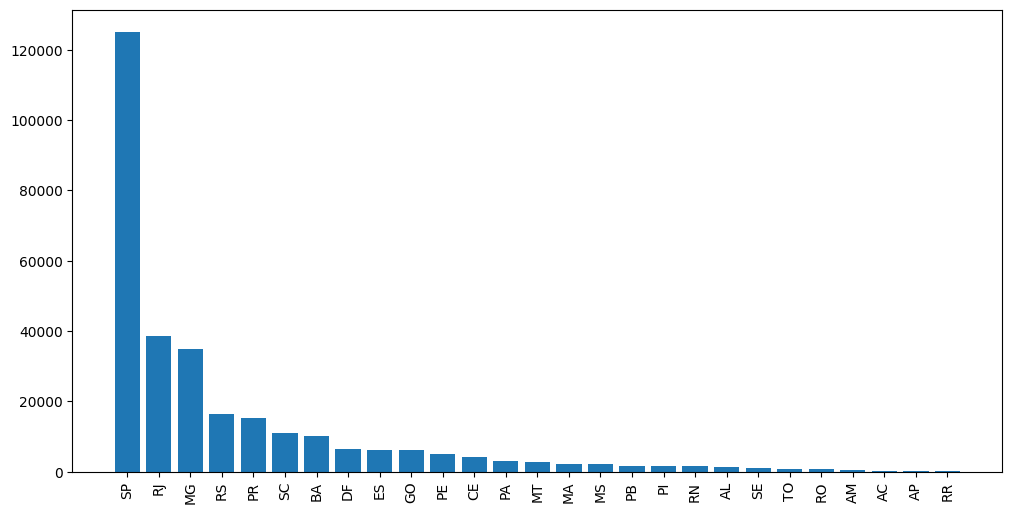

In [10]:
query= """ select  customer_state, count(customer_unique_id) as Total_Customers  from customers 
group by customer_state"""

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns=['State' ,'Customer Count'])
df= df.sort_values(by='Customer Count', ascending = False)
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.bar(df['State'], df['Customer Count'])
plt.show()

# Intermediate Queries

# 1. Calculate the number of orders per month in 2018.

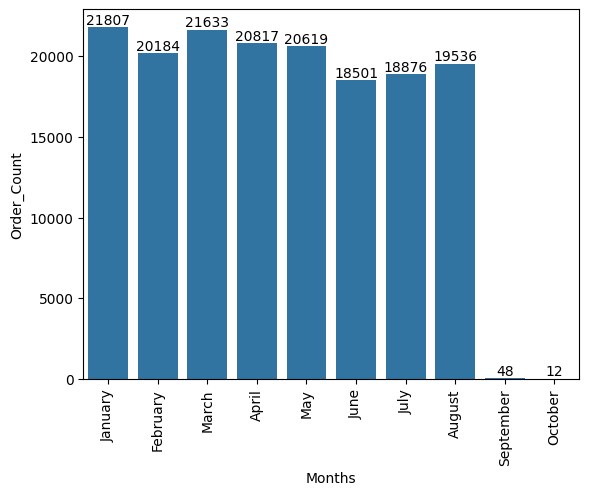

In [11]:
query= """ select monthname(order_purchase_timestamp) as Months, count(order_id) as Order_Count 
from orders where year(order_purchase_timestamp)= 2018 
group by Months """

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns= ['Months', 'Order_Count'])
Month_order=['January','February','March','April','May', 'June', 'July','August','September','October']
ax= sns.barplot(x= df['Months'], y= df['Order_Count'],data= df, order = Month_order)
ax.bar_label(ax.containers[0])
plt.xticks(rotation= 90)
# plt.title("Count of Orders by Months in 2018")
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [12]:
query= """ with cte as (
select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders join order_items
on orders.order_id=order_items.order_id 
group by orders.order_id, orders.customer_id
)
select customers.customer_city, round(avg(cte.order_count),2) as avg_order
from customers
join cte on customers.customer_id= cte.customer_id
group by customers.customer_city order by avg_order desc; """

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data)
df

,0,1
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
...,...,...
4105,sao mamede,9.00
4106,sambaiba,9.00
4107,japaratuba,9.00
4108,tuiuti,9.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [13]:
query= """ select upper(products.product_category) as Category ,
round(sum(payments.payment_value) / (select sum(payment_value) from payments) * 100 ,2) as Percent from products 
join order_items on products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id 
group by Category """
cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data, columns=['Category','Sales Percent'])
df.sort_values(by= 'Sales Percent' ,ascending=False)


,Category,Sales Percent
3,BED TABLE BATH,96.28
11,HEALTH BEAUTY,93.18
5,COMPUTER ACCESSORIES,89.13
1,FURNITURE DECORATION,80.40
15,WATCHES PRESENT,80.35
...,...,...
72,PC GAMER,0.12
66,HOUSE COMFORT 2,0.10
69,CDS MUSIC DVDS,0.07
71,FASHION CHILDREN'S CLOTHING,0.04


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
import numpy as np

In [15]:
query= """ select products.product_category, count(order_items.product_id), round(avg(order_items.price),2)
from products join order_items on products.product_id=order_items.product_id
group by products.product_category """

cur.execute(query)

data= cur.fetchall()

df=pd .DataFrame(data, columns=['Category','Order Count','Price'])
# arr1=df['Order Count']
# arr2=df['Price']
# np.corrcoef([arr1,arr2])             # Using numpy
df['Order Count'].corr(df['Price'])    # Using pandas 

np.float64(-0.10631514167157556)

### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

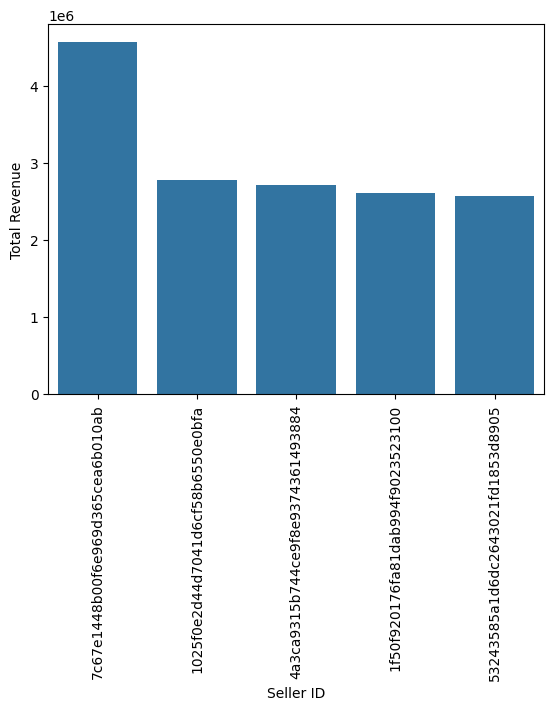

In [16]:
query= """ select * ,dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, round(sum(payments.payment_value)) as revenue 
from order_items join payments on order_items.order_id=payments.order_id 
group by order_items.seller_id) as a """

cur.execute(query)

data= cur.fetchall()

df=pd .DataFrame(data, columns=['Seller ID','Total Revenue','Seller Rank'])
df=df.head(5)
sns.barplot(data=df,x= 'Seller ID', y= 'Total Revenue')
plt.xticks(rotation=90)
plt.show()

### Advanced Queries

### 1. Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """ select customer_id, order_purchase_timestamp, payment, avg(payment)
over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as moving_avg from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from orders join payments on payments.order_id= orders.order_id) as a """

cur.execute(query)

data= cur.fetchall()

df=pd .DataFrame(data, columns=['Customer Id','Order Purchase Timestamp','Payment', 'Moving Average'])
df

,Customer Id,Order Purchase Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [18]:
query= """ select years, months, payment, sum(payment)
over(order by years,months) as cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id group by years, months order by years, months) as a """

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data, columns=['Years','Months','Payment', 'Cumulative Sales'])
df['Cumulative Sales'] =df['Cumulative Sales'].apply(lambda x: '{:.2f}'.format(x))   # .2f represents number of digit after decimal
df

,Years,Months,Payment,Cumulative Sales
0,2016,9,2270.16,2270.16
1,2016,10,531814.32,534084.48
2,2016,12,176.58,534261.06
3,2017,1,1246392.36,1780653.42
4,2017,2,2627172.09,4407825.51
5,2017,3,4048772.40,8456597.91
6,2017,4,3760092.27,12216690.18
7,2017,5,5336269.38,17552959.56
8,2017,6,4601487.42,22154446.98
9,2017,7,5331446.28,27485893.26


### 3. Calculate the year-over-year growth rate of total sales.

In [19]:
query= """with cte as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id group by years order by years) 
select years, payment, lag (payment,1) over(order by years)as previous_year_sale,
((payment - lag (payment,1) over(order by years))/ lag(payment,1) over(order by years)) * 100 as yoy
from cte """

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns=['Years', 'Current Year Sale', 'Previous Year Sale', 'YOY % growth'])
df

,Years,Current Year Sale,Previous Year Sale,YOY % growth
0,2016,534261.06,NaN,NaN
1,2017,65247720.55,534261.06,12112.703758
2,2018,78297867.47,65247720.55,20.000924


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another 
### purchase within 6 months of their first purchase.

In [28]:
query= """ with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders  
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order 
from a join orders 
on orders.customer_id=a.customer_id 
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month) 
group by a.customer_id)

select (count(distinct a.customer_id)/ count(distinct b.customer_id)) *100 
from a left join b
on a.customer_id=b.customer_id
"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data)
df

,0
0,None


### 5. Identify the top 3 customers who spent the most money in each year.

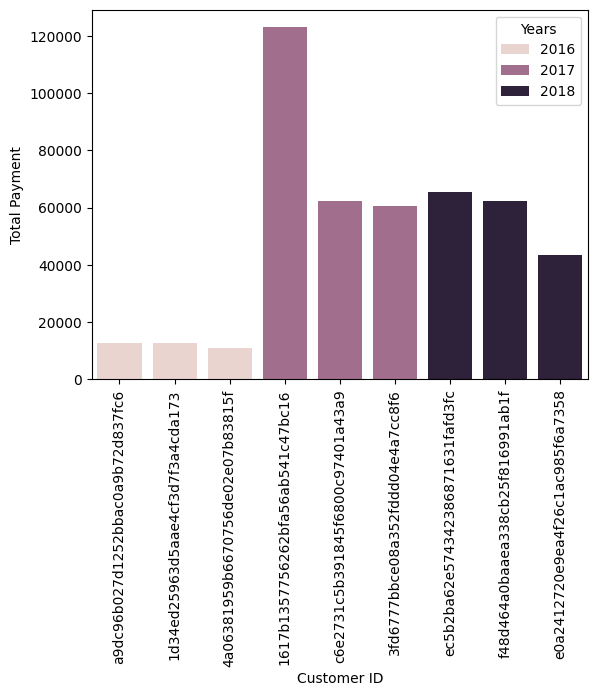

In [31]:
query= """ select years, customer_id, round(total_payment), d_rank from 
(select year(orders.order_purchase_timestamp) years, 
orders.customer_id,
sum(payments.payment_value) total_payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc ) d_rank
from orders join payments 
on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3 """

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data,columns=['Years','Customer ID','Total Payment','Rank'])
sns.barplot(x='Customer ID', y='Total Payment', data=df ,hue= 'Years')
plt.xticks(rotation=90)
plt.show()